# Digital Room Correction
### with TCPi Channel and ESP32 as Server

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from pathfinder import Pathfinder

# abs_paths = ['']
# Pathfinder.relative_paths_from_abs(abs_paths)

relative_paths = [['..', '..', '..', '..', 'SigmaDSP', 'bitbucket', 'github', 'codes'],
                  ['..', '..', '..', '..', 'Signal Generators', 'bitbucket', 'github', 'codes'],
                  ['..', '..', '..', '..', 'Utilities', 'bitbucket', 'github', 'codes'], 
                  ['..', '..', '..', '..', 'TCPi', 'bitbucket', 'github', 'codes']] 

Pathfinder.append_relative_paths(relative_paths)
# =====================================================

import pandas as pd

#https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)
# =====================================================

## TCPi

import time 

from tcpi.protocols.TCPIP1701 import class_finder
# =====================================================

### Client

from tcpi.bus.tcpi_client import I2C as TcpI2C_client

tcpi_client = TcpI2C_client(class_finder)
server_ip = '192.168.101.36'
tcpi_client.connect(server_ip = server_ip, server_port = 8086)
time.sleep(1)
# =====================================================

## DSP processor

from sigma.sigma_dsp.adau import ADAU1401

# dsp = ADAU1401(bus = bus)
dsp = ADAU1401(bus = tcpi_client)
# =====================================================

def reset_dsp():
    CMD_RESET_DSP = b'Reset_DSP'
    tcpi_client.send(CMD_RESET_DSP)
    time.sleep(0.5)  


[Connecting server: ('192.168.101.36', 8086)]

[Connected with server: ('192.168.101.36', 8086)]


## SigmaStudio project file

In [3]:
import os

SigmaStudio_project_file_url = os.sep.join(['..', 'SigmaStudio projects', 'projects', 'demo', 'demo.dspproj'])
SigmaStudio_project_file_url

'..\\SigmaStudio projects\\projects\\demo\\demo.dspproj'

![](https://github.com/Wei1234c/DRC/blob/master/SigmaStudio%20projects/projects/demo/demo.png?raw=true)

## Factory

In [4]:
import os
from sigma.factory import Factory 

project_xml_file_url = os.sep.join(['..', 'SigmaStudio projects', 'projects', 'demo', 'demo.xml'])
class_files_root_url = os.sep.join(['..', '..', '..', '..', 'SigmaDSP', 'bitbucket', 'github', 'codes', 'sigma', 'sigma_studio', 'toolbox', 'cells']) 

factory = Factory(project_xml_file_url = project_xml_file_url,
                  class_files_root_url = class_files_root_url,
                  dsp = dsp
                 )

## IC

In [5]:
# showing cells, algorithms, parameters of this project

ic = factory.get_ic()
# ic.df

## Cells 

In [6]:
cells = factory.get_cells(ic)

### Get Cell objects ready for use.

In [7]:
# # un-comment this to generate a script to embody Cell objects.

# for o in factory.get_cells_manifest():
#     print(o) 

In [8]:
# assign variable names to each Cell for easy access.

delay0 = cells['Delay0']  # Fractional Delay( 1 )
delay1 = cells['Delay1']  # Fractional Delay( 1 )
fir0 = cells['FIR0']  # FIR( 1 )
fir1 = cells['FIR1']  # FIR( 1 )
gain0 = cells['Gain0']  # Gain (no slew)( 1 )
gain1 = cells['Gain1']  # Gain (no slew)( 1 )
invert0 = cells['Invert0']  # Invert( 1 )
invert1 = cells['Invert1']  # Invert( 1 )
merger0 = cells['Merger0']  # Signal MixerC
merger1 = cells['Merger1']  # Signal MixerC
mute00 = cells['Mute00']  # No Slew (Standard)( 1 )
mute01 = cells['Mute01']  # No Slew (Standard)( 1 )
mute10 = cells['Mute10']  # No Slew (Standard)( 1 )
mute11 = cells['Mute11']  # No Slew (Standard)( 1 )
param_eq0 = cells['Param EQ0']  # PEQ1Chan - Double Precision( 1 )
param_eq1 = cells['Param EQ1']  # PEQ1Chan - Double Precision( 1 )
pink_flt1 = cells['Pink Flt1']  # Pink Noise Filter( 1 )
source_switch = cells['Source_Switch']  # Stereo SW Slew( 3 )
sw_noise = cells['SW_noise']  # Mono SW Slew( 2 )
tone = cells['Tone']  # Tone Synthesis (lookup/sine)( 1 )
white_noise = cells['White_Noise']  # White Noise( 1 )

# Procedures

In [9]:
channels = {'left' : {'idx_channel': 0,
                      'muter': mute00,
                      'gain' : gain0,
                      'delay': delay0,
                      'peq'  : param_eq0,
                      'fir'  : fir0},
            'right': {'idx_channel': 1,
                      'muter': mute11,
                      'gain' : gain1,
                      'delay': delay1,
                      'peq'  : param_eq1,
                      'fir'  : fir1}}
    
def mute_all(value = True):
    for channel in channels.values():
        channel['muter'].mute(value)
        
def source_select_white_noise():
    source_switch.switch(1)
    invert1.enable(False)
    sw_noise.switch(1)
    
def source_select_white_noise_inverted():
    source_switch.switch(1)
    invert1.enable(True)
    sw_noise.switch(1)
    
def source_select_normal():
    source_switch.switch(2)
    mute_all(False)

def measure_channel(channel_name):
    mute_all(True)
    source_select_white_noise()
    channels[channel_name]['muter'].mute(False)
    
def set_peq_coeffs(channel_name, coeffs):   
    muter = channels[channel_name]['muter'] 
    muter.mute(True)
    channels[channel_name]['peq'].set_coefficients_values(coeffs)
    muter.mute(False)    

def reset_peq_coeffs(channel_name):   
    muter = channels[channel_name]['muter'] 
    muter.mute(True)
    channels[channel_name]['peq'].reset_coefficients()
    muter.mute(False)
    
def reset_delays():
    delay0.set_delayed_percentage(0)
    delay1.set_delayed_percentage(0)
    
def reset_gains():
    gain0.set_gain(1)
    gain1.set_gain(1)

In [10]:
from pathfinder import Pathfinder

relative_paths = [['..', '..', '..', '..', '..', '..', '資料科學', 'Allen Downey', 'Think DSP', 'code'],
                  ['..', '..', '..', '..', 'AutoEq'],
                  ['..', 'codes']]

Pathfinder.append_relative_paths(relative_paths)

from drc.measurements.frequency.responses import FrequencyResponse
from drc.measurements import Sampler
from drc.tuners.response.equalizer import ResponseEqualizer
from drc.filters.peq import PEQs


# FrequencyResponse.FREQUENCY_TO_CENTER = 1000
# FrequencyResponse.FREQUENCY_TO_CENTER = [200, 8000]

# Microphone settings

In [11]:
from drc.measurements.frequency.calibrations.miniDSP import UMIK1

# fn_calibration = 'UMIK-1 cal file 7103946.txt'
fn_calibration = 'UMIK-1 cal file 7103946_90deg.txt'

mic = UMIK1()
mic.load(file_name = fn_calibration, n_header_lines = 2);

# Utilities for sampling

In [12]:
# from pprint import pprint

# pprint(Sound.scan_devices(0))

In [13]:
def probe(n_samplings = 10):
    return mic.get_frequency_response(input_device_idx = 1, n_samplings = n_samplings)

def probe_channels(wait_sec = 2):
    time.sleep(1)
    
    for channel_name in channels.keys():
    
        measure_channel(channel_name)
        time.sleep(wait_sec) 
        
        fr, _ = probe()        
        fr.name = channel_name
        fr.plot_graph(raw_plot_kwargs= {'color': 'green', 'alpha': 0.5},
                      smoothed_plot_kwargs= {'color': 'red', 'alpha': 0.5});

# Delay Alignment and Gain Balancing - before AutoEQ

In [14]:
from drc.tuners.delay.aligner import DelayAligner
from drc.tuners.gain.balancer import GainBalancer

In [15]:
reset_dsp()

In [16]:
source_select_normal()
source_select_white_noise_inverted()

## Delay alignment
### The speaker closest to microphone does the delay

In [17]:
fractional_delay = delay0
estimated_distance_difference_cm = 4.0

optimized_delay_ms: 0.11888111888111888
distance_difference_cm:4.08


0.1188810169696808

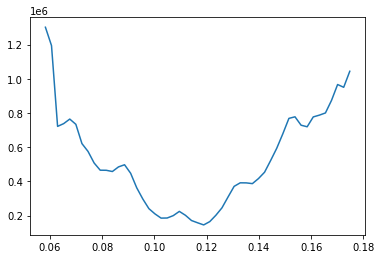

In [18]:
reset_gains()
reset_delays()
time.sleep(1)

ms_delays, powers, optimized_delay_ms, distance_difference_cm = \
    DelayAligner.optimize(fractional_delay = fractional_delay, 
                          estimated_distance_difference_cm = estimated_distance_difference_cm,
                          input_device_idx = 1,
                          probe_range = (0.5, 1.5), bins = 51, 
                          wait_between_ms = 100)    

plt.plot(ms_delays, powers);

print(f'optimized_delay_ms: {optimized_delay_ms}\ndistance_difference_cm:{distance_difference_cm}')
delay0.get_delayed_ms()

## Gain balancing

### The speaker closest to microphone does the attenuate

In [19]:
gain_cell = gain0
gain_cell_base = gain1

optimized_gain: 0.6079999999999999


0.6079999208450317

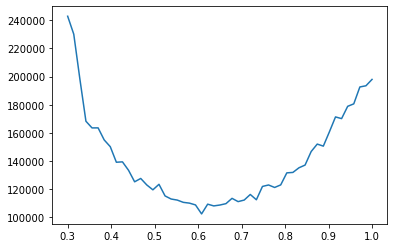

In [20]:
reset_gains()
time.sleep(1)

gains, powers, optimized_gain = \
    GainBalancer.optimize(gain_cell = gain_cell, input_device_idx = 1,
                          gain_range = (0.3, 1), bins = 51,
                          wait_between_ms = 100)
plt.plot(gains, powers);

print(f'optimized_gain: {optimized_gain}')
gain0.get_gain()

### Directly measure the SPL difference between channels and set the gain (preferred method).

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


spl_target 45.18595179258228
spl 48.55055910647352
optimized_gain_dB -3.3646073138912413
optimized_gain 0.6788433790206909
spl_balanced 45.259004982940176


C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


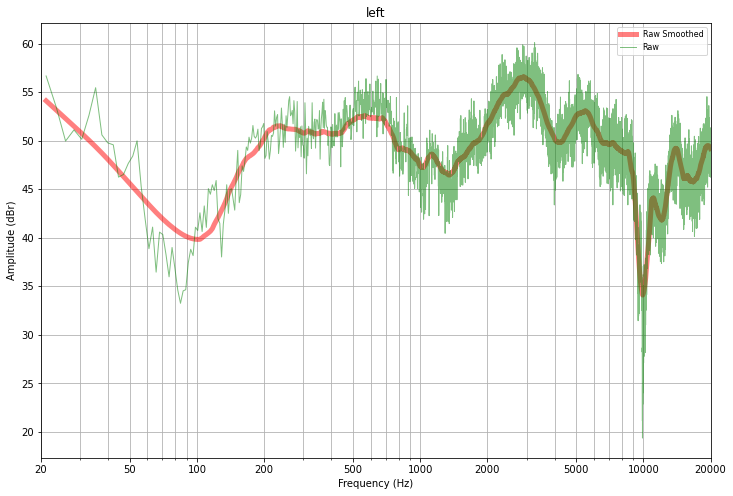

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


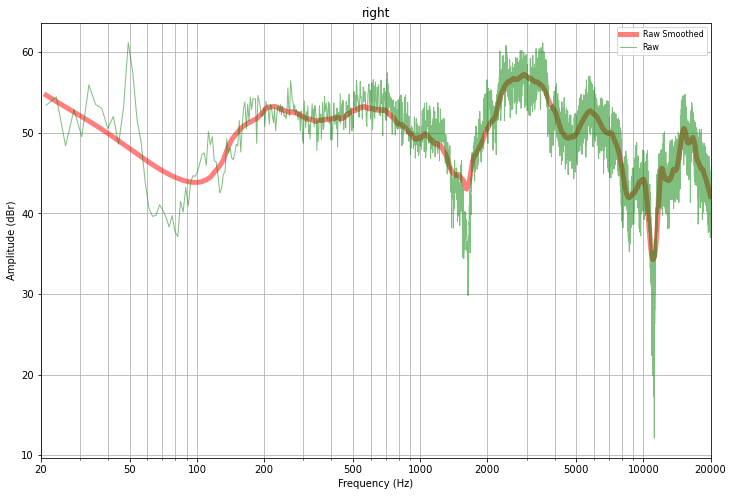

In [21]:
source_select_normal()
source_select_white_noise()

reset_gains()
time.sleep(1)

MEAN_SPL_FREQ_LIMITS = (200, 6000)

spl_target, spl, optimized_gain_dB, spl_balanced = \
    GainBalancer.balance(gain_cell, gain_cell_base, input_device_idx = 1, freq_lims = MEAN_SPL_FREQ_LIMITS)

print('spl_target', spl_target)
print('spl', spl)
print('optimized_gain_dB', optimized_gain_dB) 
print('optimized_gain', gain0.get_gain()) 
print('spl_balanced', spl_balanced)

probe_channels()

# AutoEQ - Frequency Response Tuning

# Reset delays and gains

In [22]:
reset_gains()
reset_delays()

In [23]:
source_select_normal()
source_select_white_noise()

## Reset PEQ filters

In [24]:
for channel_name in channels.keys():
    reset_peq_coeffs(channel_name)

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


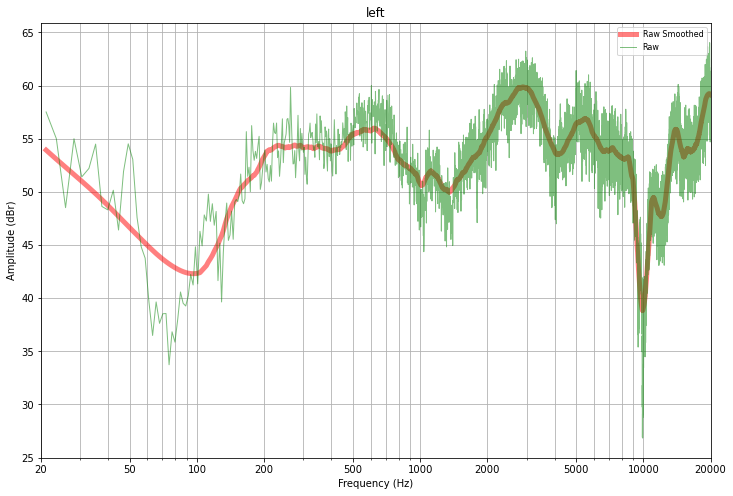

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


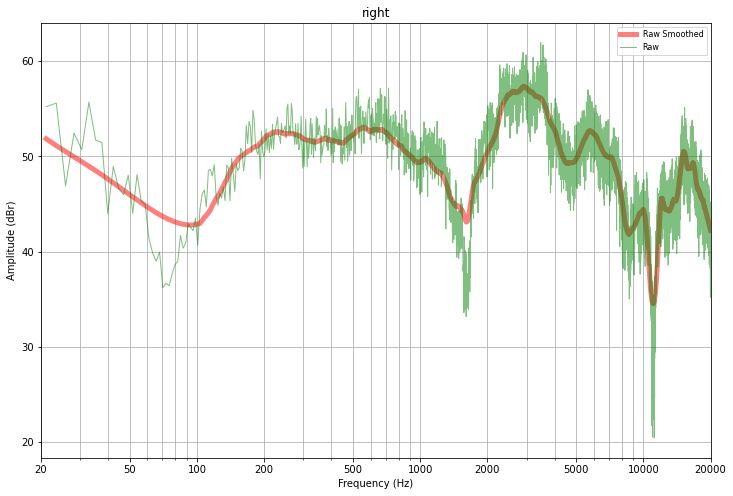

In [25]:
probe_channels()

# Calculate and apply PEQ coefficients 
Note:
- In [AutoEq](https://github.com/jaakkopasanen/AutoEq), measurement is centered (shift SPL to 0) at frequency 1000 Hz before compared with the compensation (target), the SPL at 1000 Hz may vary significantly among measurements, therefore the gain of equalization fluctuates a lot.
- Measurement here is centered according the mean SPL of 100~8000 Hz before auto-equaization.

In [26]:
model_name = 'JamBox'

In [27]:
import time


n_filters = 10
max_gain_dB = 12
bass_boost_gain = 0

def equalize(channel_name, compensation,
             n_filters = n_filters, max_gain_dB = max_gain_dB, bass_boost_gain = bass_boost_gain,
             calibration_path = None,
             wait_sec = 2):

    measure_channel(channel_name)
    time.sleep(wait_sec)

    _, fr_measurement = probe()

    measurement, peqs, n_peq_filters, peq_max_gains = \
        ResponseEqualizer.get_peq_filters(fr_measurement,
                                          compensation,
                                          max_filters = n_filters,
                                          max_gain_dB = max_gain_dB,
                                          bass_boost_gain = bass_boost_gain)
    
    peqs.dump(f'{model_name} {channel_name} PEQ filters.txt')
    set_peq_coeffs(channel_name, peqs.get_coefficient_sets_values(n_filters = n_filters))

    return measurement, peqs


# compensation_path = 'compensation/harman_over-ear_2018.csv'
compensation_path = 'compensation/zero.csv'
compensation = FrequencyResponse.read_from_csv(compensation_path)

def equalize_channels():    
    for channel_name in channels.keys():
        measurement, peqs = equalize(channel_name, compensation = compensation,
                                     n_filters = n_filters, max_gain_dB = max_gain_dB,
                                     bass_boost_gain = bass_boost_gain)

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


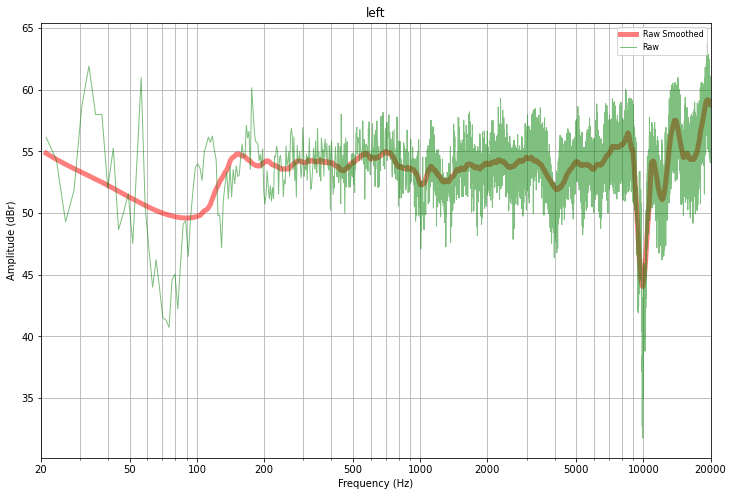

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


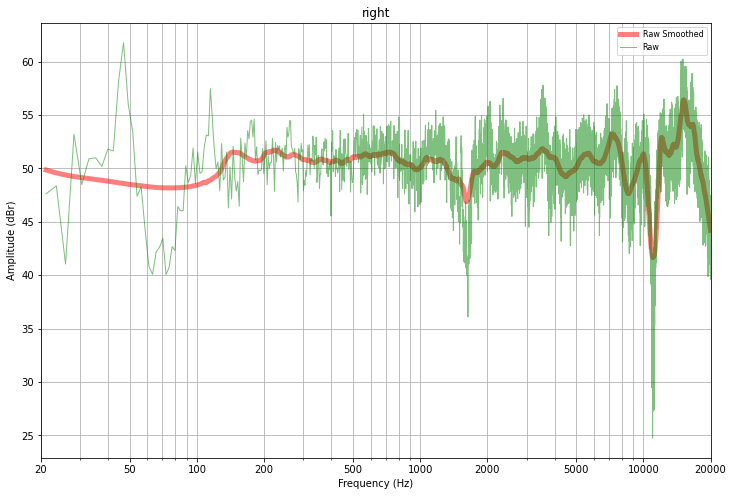

In [28]:
equalize_channels()    
probe_channels()

# PEQ settings

JamBox left PEQ filters:
  type  freq_Hz  gain_dB      Q
0   PK     61.7    4.950  0.770
1   PK    109.8    6.425  1.130
2   PK    220.9   -3.250  1.725
3   PK    630.9   -3.292  2.078
4   PK    919.7    2.542  2.052
5   PK   1376.5    3.226  3.134
6   PK   2805.9   -6.932  2.289
7   PK   5557.5   -3.588  4.311
8   PK  10313.9    5.365  1.461

JamBox right PEQ filters:
  type  freq_Hz  gain_dB      Q
0   PK     17.1   -3.340  1.052
1   PK     64.4    4.649  0.863
2   PK    103.1    6.187  1.426
3   PK    195.6   -2.991  0.922
4   PK    602.9   -2.924  2.760
5   PK   1537.7    7.737  2.353
6   PK   2914.2  -11.883  1.234
7   PK   6078.8   -6.832  3.150
8   PK   8625.9    7.758  0.276
9   PK  12385.4    0.927  1.269



C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


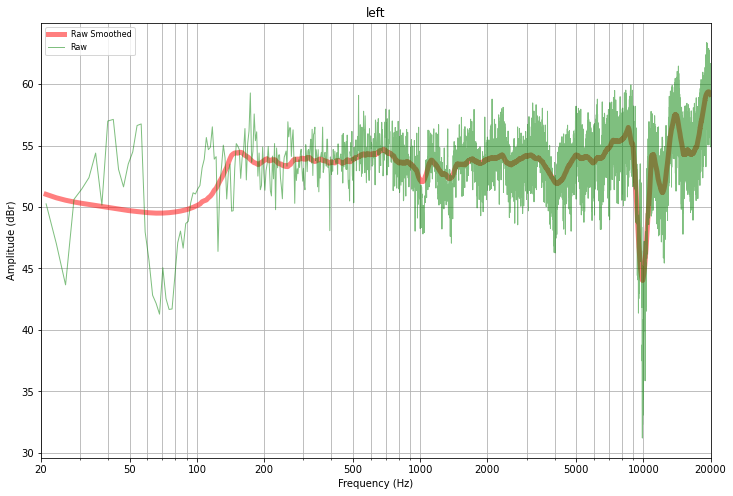

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


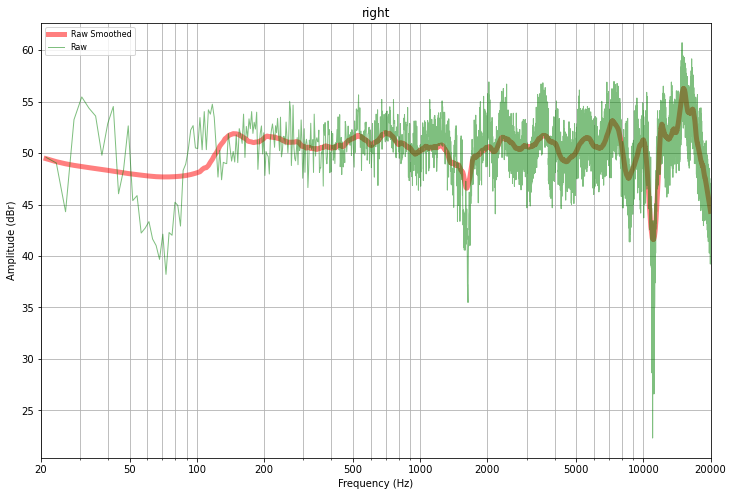

In [29]:
peqs = PEQs()

for channel_name in channels.keys():
    peqs.load(f'{model_name} {channel_name} PEQ filters.txt')
    set_peq_coeffs(channel_name, peqs.get_coefficient_sets_values(n_filters = n_filters))
    
    print(f'{model_name} {channel_name} PEQ filters:')
    print(pd.DataFrame(peqs.param_sets))
    print()    

probe_channels()

# Delay Alignment and Gain Balancing - after AutoEQ

In [30]:
from drc.tuners.delay.aligner import DelayAligner
from drc.tuners.gain.balancer import GainBalancer

In [31]:
source_select_normal()
source_select_white_noise_inverted()

## Delay alignment
### The speaker closest to microphone does the delay
Note: Need to do delay-alignment after (not before) AutoEQ. Biquad filters are not linear-phased hence inference delay-alignment slightly. 

optimized_delay_ms: 0.13053613053613053
distance_difference_cm:4.48


0.13053605953852337

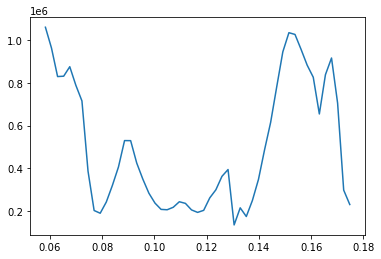

In [32]:
reset_gains()
reset_delays()
time.sleep(1)

ms_delays, powers, optimized_delay_ms, distance_difference_cm = \
    DelayAligner.optimize(fractional_delay = fractional_delay, 
                          estimated_distance_difference_cm = estimated_distance_difference_cm,
                          input_device_idx = 1,
                          probe_range = (0.5, 1.5), bins = 51, 
                          wait_between_ms = 100)    

plt.plot(ms_delays, powers);

print(f'optimized_delay_ms: {optimized_delay_ms}\ndistance_difference_cm:{distance_difference_cm}')
delay0.get_delayed_ms()

## Gain balancing

### The speaker closest to microphone does the attenuate

Note:
- Need to do gain-balancing after (not before) AutoEQ, since channels are equalized individually and the gain of each channel is altered differently.
- When trying to balance gains among channels, hereby the mean SPL of frequency 200~6000 Hz is taken into account.

### We can probe the power of a range of gains, and find the optimal one.

optimized_gain: 0.43999999999999995


0.43999993801116943

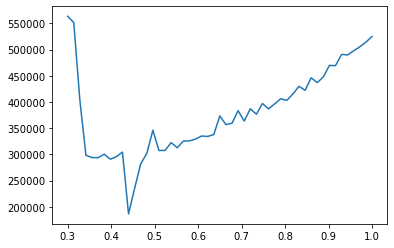

In [33]:
reset_gains()
time.sleep(1)

gains, powers, optimized_gain = \
    GainBalancer.optimize(gain_cell = gain_cell, input_device_idx = 1,
                          gain_range = (0.3, 1), bins = 51,
                          wait_between_ms = 100)
plt.plot(gains, powers);

print(f'optimized_gain: {optimized_gain}')
gain0.get_gain()

### Or we can directly measure the SPL difference between channels and set the gain (preferred method).

In [34]:
source_select_normal()
source_select_white_noise()

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


spl_target 43.7362189835466
spl 46.70961912097276
optimized_gain_dB -2.973400137426161
optimized_gain 0.7101171016693115
spl_balanced 43.64683205196044


C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


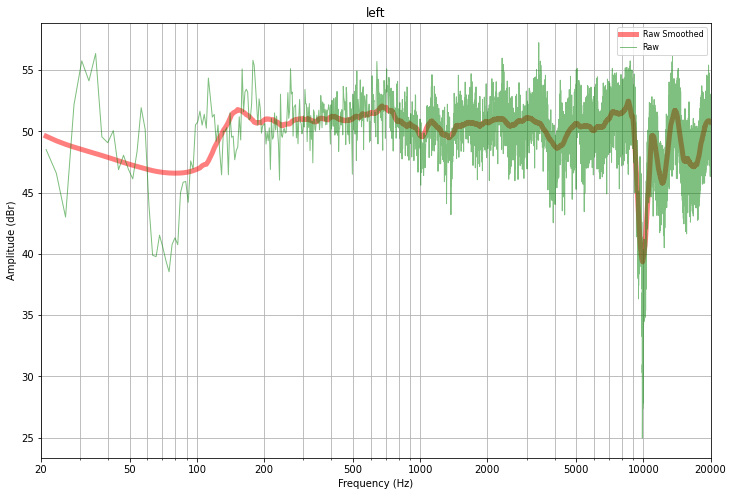

C:\Softwares\Python\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


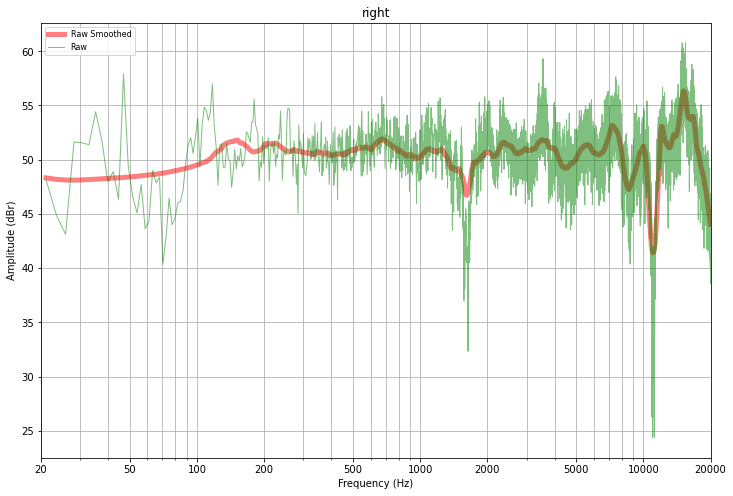

In [35]:
reset_gains()
time.sleep(1)

spl_target, spl, optimized_gain_dB, spl_balanced = \
    GainBalancer.balance(gain_cell, gain_cell_base, input_device_idx = 1, freq_lims = MEAN_SPL_FREQ_LIMITS)

print('spl_target', spl_target)
print('spl', spl)
print('optimized_gain_dB', optimized_gain_dB) 
print('optimized_gain', gain0.get_gain()) 
print('spl_balanced', spl_balanced)

probe_channels()

# Listen

In [36]:
source_select_normal()

# Close TCP channels

In [37]:
# tcpi_client.stop()